In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

data = pd.read_csv('data/train.csv')

# 2. Разделение данных на признаки (X) и целевую переменную (y)
X = data.drop('Cover_Type', axis=1)  
X = X.drop('Id', axis=1)
y = data['Cover_Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

# 4. Выбор модели
model = RandomForestClassifier(random_state=42, n_jobs=-1)


In [2]:
data_ = data

a = []
for i in range(len(data)):
    for x in range(1, 5):
        if data["Wilderness_Area" + str(x)][i]:
            a.append(x-1)

for x in range(1, 5):
    data_ = data_.drop("Wilderness_Area" + str(x), axis=1)

data_['Wilderness_Area'] = a

a.clear()
for i in range(len(data)):
    for x in range(1, 41):
        if data["Soil_Type" + str(x)][i]:
            a.append(x-1)

for x in range(1, 41):
    data_ = data_.drop("Soil_Type" + str(x), axis=1)

data_['Soil_Type'] = a

In [3]:
X_new = data_.drop('Cover_Type', axis=1)
X_new = X_new.drop('Id', axis=1)

X_new_train, X_new_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42) 


In [5]:
model.fit(X_new_train, y_train)
score = model.score(X_new_test, y_test)

In [ ]:
import joblib

# сохранение модели
joblib.dump(model, 'data/model.pkl')

['data/model.pkl']

                                    importance
Elevation                             0.253059
Soil_Type                             0.151642
Horizontal_Distance_To_Roadways       0.097886
Horizontal_Distance_To_Fire_Points    0.077281
Wilderness_Area                       0.070709
Horizontal_Distance_To_Hydrology      0.061939
Hillshade_9am                         0.057524
Vertical_Distance_To_Hydrology        0.055914
Aspect                                0.051229
Hillshade_3pm                         0.045057
Hillshade_Noon                        0.044816
Slope                                 0.032943


<Axes: >

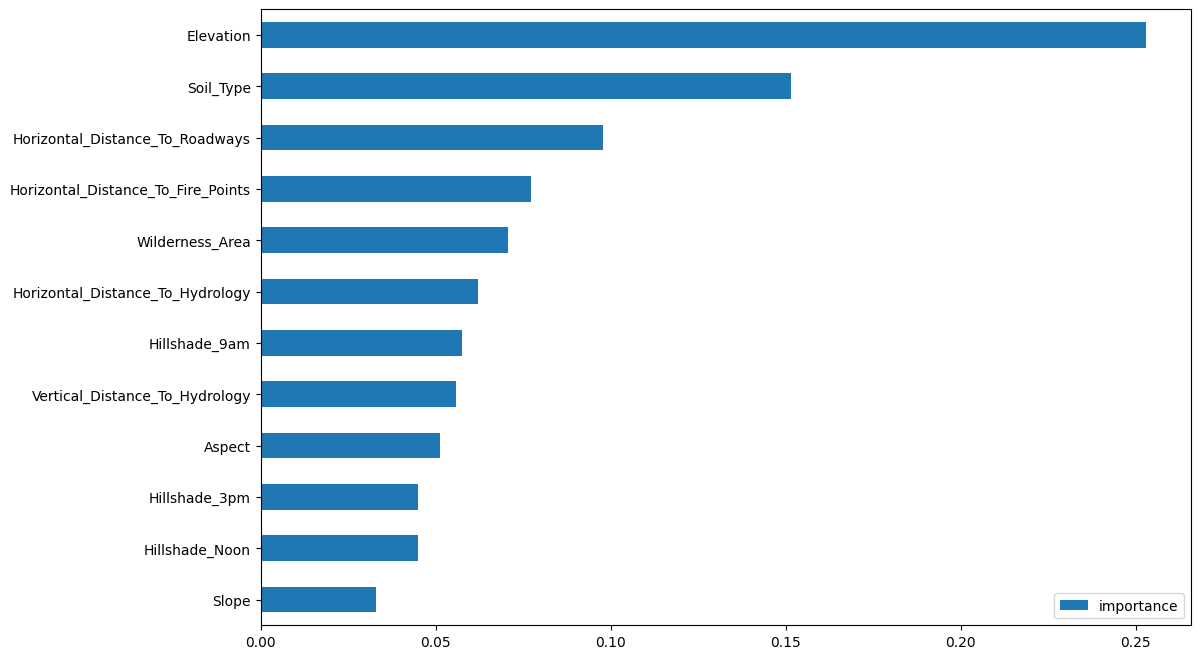

In [7]:
imp = pd.DataFrame(model.feature_importances_, index=X_new_train.columns, columns=['importance'])
print(imp.sort_values('importance')[::-1])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8))

In [ ]:

# 5. Кросс-валидация
# Используем 5-кратную кросс-валидацию
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

print(f'Test accuracy: {score:.4f}')


# Вывод результатов кросс-валидации
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean CV accuracy: {np.mean(cv_scores):.4f}')
print(f'Max CV accuracy: {np.max(cv_scores):.4f}')
print(f'Min CV accuracy: {np.min(cv_scores):.4f}')



Test accuracy: 0.8724
Cross-validation scores: [0.84380165 0.85489872 0.85241835 0.84084332 0.84787102]
Mean CV accuracy: 0.8480
Max CV accuracy: 0.8549
Min CV accuracy: 0.8408


Оптимизация гиперпараметров при помощи Bayes Search и Random Search

In [90]:
from skopt import BayesSearchCV
from skopt.space import Integer, Real

param_space = {
    'n_estimators': Integer(180, 200),
    'max_depth': Integer(50, 60),
    'min_samples_leaf': Integer(1, 2),
    'max_features': Real(0.4, 0.6, prior='uniform')
}

# Создание модели и настройка с использованием байесовской оптимизации
rf_model = RandomForestClassifier()
bayes_search = BayesSearchCV(rf_model, param_space, n_iter=20, cv=5, n_jobs=-1)
bayes_search.fit(X_train, y_train)

# Вывод наилучших гиперпараметров и оценки
print("Best Hyperparameters:", bayes_search.best_params_)
print("Best Cross-Validation Score:", bayes_search.best_score_)

rf = bayes_search.best_estimator_
print(rf.score(X_test, y_test))

Best Hyperparameters: OrderedDict({'max_depth': 54, 'max_features': 0.5210786820544161, 'min_samples_leaf': 1, 'n_estimators': 184})
Best Cross-Validation Score: 0.8571433110465018
0.8723544973544973


In [9]:

param_grid = {
    'n_estimators': range(50, 201, 10),
    'max_depth': [None]+list(range(5, 101, 5)),
    'min_samples_split': range(2, 9),
    'min_samples_leaf': range(1, 9)
}


# Настройка RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                   n_iter=16, cv=5, scoring='accuracy', n_jobs=-1, 
                                   random_state=42)


# Обучение модели
random_search.fit(X_train, y_train)

# Лучшие гиперпараметры
print("Лучшие гиперпараметры:", random_search.best_params_)
print(f'Лучшая точность: {random_search.best_score_:.4f}')
# Оценка на тестовой выборке
best_model = random_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Тестовая точность:", test_accuracy)


Лучшие гиперпараметры: {'n_estimators': 190, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}
Лучшая точность: 0.8522
Тестовая точность: 0.871031746031746


In [9]:
best_model = RandomForestClassifier(**random_search.best_params_)
best_model.fit(X_new_train, y_train)
test_accuracy = best_model.score(X_new_test, y_test)
print("Тестовая точность:", test_accuracy)

Тестовая точность: 0.8736772486772487


In [10]:
cv_scores_best = cross_val_score(best_model, X_new_train, y_train, cv=5, scoring='accuracy')

# Вывод результатов кросс-валидации
print(f'Cross-validation scores: {cv_scores_best}')
print(f'Max CV accuracy: {np.max(cv_scores_best):.4f}')
print(f'Mean CV accuracy: {np.mean(cv_scores_best):.4f}')
print(f'Min CV accuracy: {np.min(cv_scores_best):.4f}')


Cross-validation scores: [0.83842975 0.85448532 0.85572551 0.84084332 0.85035138]
Max CV accuracy: 0.8557
Mean CV accuracy: 0.8480
Min CV accuracy: 0.8384


Попытка использовать градиентный бустинг и поиск гиперпараметров

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

# Создание модели градиентного бустинга
"""model = HistGradientBoostingClassifier(
    n_estimators=100,  # Количество деревьев
    learning_rate=0.2,  # Скорость обучения
    max_depth=3,       # Максимальная глубина каждого дерева
    random_state=42, 
    n_jobs=-1
)"""

param_grid = {
    'learning_rate': [.1],
    'max_iter': range(50, 301, 50),
    'max_leaf_nodes': range(16, 41, 4),
    'max_depth': [None]+list(range(10, 31, 5))
}


# Настройка RandomizedSearchCV
model = HistGradientBoostingClassifier(random_state=42) 

model.fit(X_new_train, y_train)

print('Точность чистой модели:', model.score(X_new_test, y_test))

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                   n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, 
                                   random_state=42)

random_search.fit(X_new_train, y_train)

# Лучшие гиперпараметры
print("Лучшие гиперпараметры:", random_search.best_params_)
print(f'Лучшая точность: {random_search.best_score_:.4f}')
# Оценка на тестовой выборке
best_model = random_search.best_estimator_
test_accuracy = best_model.score(X_new_test, y_test)
print("Тестовая точность:", test_accuracy)

Точность чистой модели: 0.8611111111111112
Лучшие гиперпараметры: {'max_leaf_nodes': 32, 'max_iter': 300, 'max_depth': 20, 'learning_rate': 0.1}
Лучшая точность: 0.8592
Тестовая точность: 0.8654100529100529
